# Starbucks Promotion Strategy

Table of Contents

- [Background Information](#Background-Information)
- [Part 1 - Invariant-Metrics](#Part-1-Hypothesis-testing-for-Invariant-Metrics-(Number-of-participants-in-each-group))
- [Part 2 - Net Incremental Revenue](#Part-2-Hypothesis-testing-for-NIR-Value)
- [Part 3 - Incremental Response Value](#Part-3-Hypothesis-testing-for-IRR-Value)
- [Part 4 - Model Creation](#Part-4-Modelling)

## Background Information

This dataset was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.
    
### Optimization Strategy
Our task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, the goal is to maximize the following metrics:
    
> Incremental Response Rate (IRR)
IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (treatment) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (control).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


> Net Incremental Revenue (NIR)
NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

from test_results import test_results

C:\Users\divya\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# load in the data
train = pd.read_csv('C:/Users/divya/Downloads/Starbucks/training.csv')
train.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


In [3]:
train.shape

(84534, 10)

In [4]:
train.Promotion.value_counts()

Yes    42364
No     42170
Name: Promotion, dtype: int64

In [5]:
train.purchase.value_counts()

0    83494
1     1040
Name: purchase, dtype: int64

In [6]:
train.groupby(['Promotion','purchase'])['purchase'].count().to_frame().rename(columns={'purchase':'purchase_count'})

purchase_count
Promotion purchase                
No        0                  41851
          1                    319
Yes       0                  41643
          1                    721

# Part 1 - Hypothesis testing for Invariant Metrics (Number of participants in each group)

My first step will be to analyze the  invariant metric of number of participants in our control and experiment (one who received the promottion).

Hypothesis:
> Null hypothesis : The number of participants in control and experiment group is same

> Alternate hypothesis : The number of participants in control and experiment group is different
    
⍺ = 0.05

In [7]:
#Invariant Metrics - Number of participants in each group

In [8]:
print('Number of customers who received the promotions : {} and the number who did not receive the promotions : {}'.format(train[train['Promotion']=='Yes'].shape[0], train[train['Promotion']=='No'].shape[0]))

Number of customers who received the promotions : 42364 and the number who did not receive the promotions : 42170


In [9]:
n_treatment = train[train['Promotion']=='Yes'].shape[0]
n_control = train[train['Promotion']=='No'].shape[0]
n_control, n_treatment, train.shape[0]

(42170, 42364, 84534)

In [10]:
promotion_rate = train[train['Promotion']=='Yes'].shape[0]/train.shape[0]
non_promotion_rate = train[train['Promotion']=='No'].shape[0]/train.shape[0]
rate_difference = promotion_rate - non_promotion_rate

print('Average of Promotion     :',promotion_rate)
print('Average of Non Promotion :',non_promotion_rate)
print('Sample of Difference     :',rate_difference)

Average of Promotion     : 0.5011474672912675
Average of Non Promotion : 0.4988525327087326
Sample of Difference     : 0.00229493458253488


In [11]:
#N1 = n_control
#N2 = n_obs

me_treatment = np.sqrt(promotion_rate/n_treatment)*1.96
me_control = np.sqrt(non_promotion_rate/n_control)*1.96

#calc = (promotion_rate/train.shape[0]) + (non_promotion_rate/train.shape[0])
margin_error = np.sqrt(me_treatment*me_treatment + me_control*me_control)
sd = margin_error/1.96
Z = rate_difference/sd
p_values = stats.norm.sf(abs(Z))*2

In [12]:
p_values

0.6370594028613561

Computed P value (p_val=0.637 > ⍺=0.05) and therefore we fail to reject the null hypothesis. 

This implies that there is no statistical signifigance in the difference of our sampling populations. 

# Part 2 - Hypothesis testing for NIR Value

In this part we will analyze the NIR i.e Net Incremental Value. NIR depicts how much is made (or lost) by sending out 
the promotion. 

Hypothesis:
> Null hypothesis : NetIncrementalRevenue = 0 

> Alternate hypothesis : NetIncrementalRevenue > 0 
    

Our Alpha value with the Bonferroni Correction:
    $$Bonferroni Correction = \frac{\alpha}{number-of-measures} = 0.025$$
    
where $$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

In [13]:
# Finding our observed statistic 
purchase_treatment = train[train['Promotion'] == "Yes"].purchase.sum()
customer_treatment = train[train['Promotion'] == "Yes"].shape[0]
purchase_control = train[train['Promotion'] == "No"].purchase.sum()
customer_control = train[train['Promotion'] == "No"].shape[0]
NIR = ((10 * purchase_treatment) - (0.15 * customer_treatment)) - (10 * purchase_control)
NIR

-2334.5999999999995

In [14]:
# Bootstraping our differences to get a model of the distribution for our null

NIRs = []
p_treatment = []
c_treatment = []
p_control = []
c_control = []
for _ in range(10000):
    bootstrap = train.sample(10000, replace=True)
    
    purchase_treatment = bootstrap[bootstrap['Promotion'] == "Yes"].purchase.sum()
    customer_treatment =  bootstrap[ bootstrap['Promotion'] == "Yes"].shape[0]
    
    purchase_control =  bootstrap[ bootstrap['Promotion'] == "No"].purchase.sum()
    customer_control =  bootstrap[ bootstrap['Promotion'] == "No"].shape[0]
    
    NIRs.append(((10 * purchase_treatment) - (0.15 * customer_treatment)) - (10 * purchase_control))
    p_treatment.append(purchase_treatment)
    c_treatment.append(customer_treatment)
    p_control.append(purchase_control)
    c_control.append(customer_control)

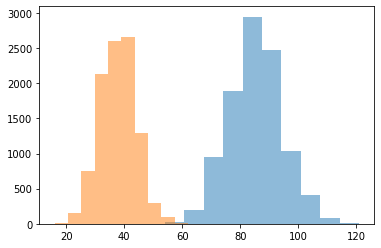

In [15]:
#confirming the normal ditribution of treatment and control with bootstrapping
plt.hist(p_treatment, alpha=0.5);
plt.hist(p_control, alpha=0.5);

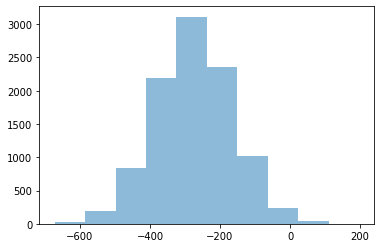

In [16]:
#confirming the normal ditribution of NIR with bootstrapping
plt.hist(NIRs, alpha=0.5);

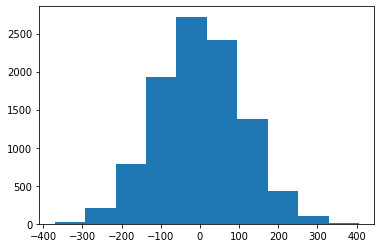

In [17]:
#samples for null hypothesis
null_val = np.random.normal(0, np.std(NIRs), 10000)
plt.hist(null_val);

In [18]:
(NIRs > null_val).mean()

0.0375

In [19]:
(NIRs < null_val).mean()

0.9625

Our P value (p_val_NIR=0.0375 > ⍺=0.025)  and  therefore we fail to reject our null hypothesis. 
This implies that there is no statistical signifigant increase in NIR (what we want to optimise). 

However, our data indicates we signifigantly REDUCED the NIR with this campaign. Not what we want...

In [20]:
(NIRs!= null_val).mean()

1.0

If you recall, the p-value is in between 0 and 1. 
The higher the p-value, the more likely that we fail to reject the null hypothesis. 
In this example, we got a 1.0, which means that our null is correct: No increase in NIR

# Part 3 - Hypothesis testing for IRR Value

In this part we will analyze the IRR i.e Incremental Response Value. IRR depicts how many more customers purchased the 
product with the promotion, as compared to if they didn't receive the promotion

Hypothesis:
> Null hypothesis : IncrementalResponseValue = 0 

> Alternate hypothesis : IncrementalResponseValue > 0 
    

Our Alpha value with the Bonferroni Correction:
    $$Bonferroni Correction = \frac{\alpha}{number-of-measures} = 0.025$$
    
Where  $$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


In [21]:
# Finding our observed statistic 
purchase_treatment = train[train['Promotion'] == "Yes"].purchase.sum()
customer_treatment = train[train['Promotion'] == "Yes"].shape[0]
purchase_control = train[train['Promotion'] == "No"].purchase.sum()
customer_control = train[train['Promotion'] == "No"].shape[0]
IRR = purchase_treatment/customer_treatment - purchase_control/customer_control
IRR

0.009454547819772702

In [22]:
# Bootstraping our differences to get a model of the distribution for our null
IRRs = []
p_treatment = []
c_treatment = []
p_control = []
c_control = []
for _ in range(5000):
    bootstrap = train.sample(5000, replace=True)
    
    purchase_treatment = bootstrap[bootstrap['Promotion'] == "Yes"].purchase.sum()
    customer_treatment =  bootstrap[ bootstrap['Promotion'] == "Yes"].shape[0]
    
    purchase_control =  bootstrap[ bootstrap['Promotion'] == "No"].purchase.sum()
    customer_control =  bootstrap[ bootstrap['Promotion'] == "No"].shape[0]
    
    IRR = purchase_treatment/customer_treatment - purchase_control/customer_control
    IRRs.append(IRR)
    p_treatment.append(purchase_treatment)
    c_treatment.append(customer_treatment)
    p_control.append(purchase_control)
    c_control.append(customer_control)


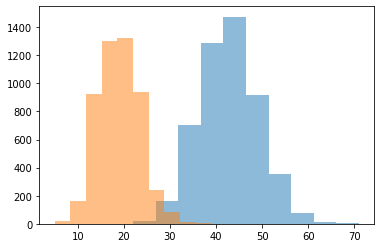

In [23]:
#confirming the normal distribution of treatment and control after bootstrapping
plt.hist(p_treatment, alpha=0.5);
plt.hist(p_control, alpha=0.5);

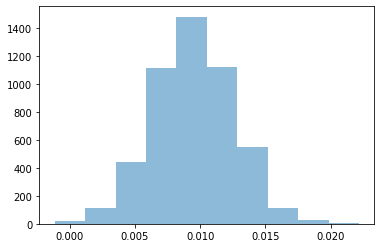

In [24]:
#confirming normal ditribution of IRR
plt.hist(IRRs, alpha=0.5);

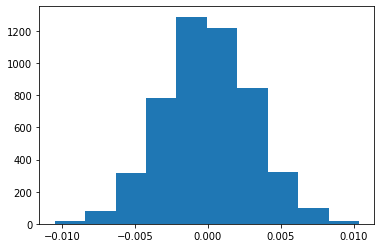

In [25]:
#samples for null hypothesis
null_val = np.random.normal(0, np.std(IRRs), 5000)
plt.hist(null_val);

In [26]:
(IRRs > null_val).mean()

0.9854

In [27]:
(IRRs < null_val).mean()

0.0146

Our P value (p_val_IIR=0.0146 < ⍺=0.025), and therefore we reject the H0-null hypothesis. 
This implies that there is a statistical increase in IRR between our control and experiemental group. 

So, we can see that our campaign does have a positive affect on the number of customers who purchased 
the product with the promotion, as compared to if they didn't receive the promotion.

# Part 4 - Modelling

Here we shall a model that can accuractely predict if a customer will be responsive to the campaign.

We will use the only the data from treatment group and the purchases from the control group for the model creation

In [28]:
train_exp = train[train['Promotion']=='Yes']
train_ctrl = train[(train['Promotion']=='No')&(train['purchase']==1)]

In [29]:
train_exp['purchase'].value_counts()

0    41643
1      721
Name: purchase, dtype: int64

In [30]:
train_ctrl['purchase'].value_counts()

1    319
Name: purchase, dtype: int64

In [31]:
final = pd.concat([train_exp, train_ctrl])
final.shape

(42683, 10)

In [32]:
final.purchase.value_counts()

0    41643
1     1040
Name: purchase, dtype: int64

In [33]:
del train_ctrl, train_exp

In [34]:
#dropping the columns
drop_cols = ['ID','Promotion']
final = final.drop(drop_cols, axis=1)

In [35]:
#separate the target column
X = final.drop(['purchase'], axis=1)
y = final['purchase']

In [36]:
#split the dataset into train and validation
X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size = 0.2, random_state=123)

#Handling the Unbalanced dataset
sm = SMOTE(random_state=42, ratio=1.0)
X_balanced_train, Y_balanced_train = sm.fit_resample(X_train, Y_train)
X_balanced_train = pd.DataFrame(X_balanced_train, columns=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7'])
Y_balanced_train = pd.Series(Y_balanced_train)

In [38]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [39]:
xgb_1 = XGBClassifier(n_estimators=1000, max_depth=5, learning_rate = 0.001, random_state=123)
xgb_1.fit(X=X_balanced_train, y=Y_balanced_train.values.ravel(), eval_set=[(X_valid, Y_valid)], eval_metric=f1_eval, early_stopping_rounds=10, verbose=10)

[0]	validation_0-error:0.268478	validation_0-f1_err:0.934747
Multiple eval metrics have been passed: 'validation_0-f1_err' will be used for early stopping.

Will train until validation_0-f1_err hasn't improved in 10 rounds.
[10]	validation_0-error:0.268478	validation_0-f1_err:0.934747
Stopping. Best iteration:
[0]	validation_0-error:0.268478	validation_0-f1_err:0.934747



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.001,
              max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
              n_estimators=1000, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=123, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1)

In [40]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    test = df
    
    preds = xgb_1.predict(test)
    promotion = []
    for pred in preds:
        if pred:
            promotion.append('Yes')
        else:
            promotion.append('No')
    promotion = np.array(promotion)
    
    
    return promotion

In [41]:
test_results(promotion_strategy)

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0188.

Your nir with this strategy is 189.00.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.018752758431748714, 189.0)